In [1]:
import os
import torch
from prepare_datasets import prepare_datasets
from build_dataloader import set_seed
from perform_grid_search import perform_grid_search
from train_test import train, validate
from model import GAT
from build_dataloader import GraphDataset, collate_fn
from dgl.dataloading import GraphDataLoader
from sklearn.metrics import accuracy_score, f1_score
from performance_visualizations import plot_hyperparameter_boxplots
from perform_cv_early_stopping import perform_cv_early_stopping
import pandas as pd

c:\Users\barbo\brain classifier repo\brain_classifier\.venv\lib\site-packages\torchdata\datapipes\__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()
c:\Users\barbo\brain classifier repo\brain_classifier\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set random seed for reproducibility
set_seed(42)
base_dir = os.path.dirname(os.getcwd())

In [3]:
# Prepare datasets
datasets, feature_names_sc, feature_names_combined = prepare_datasets(base_dir, test_size = 0.15, random_state = 42)

In [4]:
dataset_name = 'sc_fc'
train_graphs = datasets[f'train_graphs_{dataset_name}']
train_labels = datasets[f'train_labels_{dataset_name}']
test_graphs = datasets[f'test_graphs_{dataset_name}']
test_labels = datasets[f'test_labels_{dataset_name}']

In [5]:
# First hyperparameter grid
param_grid = {
    'num_heads': [1, 2, 3, 4],
    'out_channels': [8, 16],
    'num_epochs': [5],
    'learning_rate': [1e-1, 1e-2, 1e-3, 1e-4],
    'weight_decay': [0, 1e-5, 1e-4]
}

In [12]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Perform grid search with K-fold cross-validation on the training set
best_params, best_val_f1, best_val_accuracy, results_df = perform_grid_search(
    train_graphs=train_graphs,
    train_labels=train_labels,
    num_splits=5,
    param_grid=param_grid,
    batch_size=32,
    model_class=GAT,
    device=device
)

In [ ]:

print("Best Hyperparameters (based on average validation F1):")
print(best_params)
print(f"Best Average Validation F1 Score: {best_val_f1}")
print(f"Best Average Validation Accuracy: {best_val_accuracy}")

Best Hyperparameters (based on average validation F1):
{'num_heads': 2, 'out_channels': 8, 'learning_rate': 0.001, 'weight_decay': 0}


NameError: name 'best_val_f1' is not defined

In [15]:
# Save results_df to a CSV file for later analysis
#results_df.to_csv('first_grid_search_sc_combined.csv', index=False)

In [ ]:
import pandas as pd
results_df_1 = pd.read_csv('first_grid_search_sc_combined.csv')

In [ ]:
from performance_visualizations import get_top_results

top_results_df_1 = get_top_results(
    results_df=results_df_1,
    hyperparameters=['learning_rate', 'num_heads', 'weight_decay', 'out_channels'],
    metric='val_f1',
    percentile=2,
    print_flag=True
)

c:\Users\barbo\brain classifier repo\brain_classifier\src1\performance_visualizations.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_results_df[hyperparameters] = top_results_df[hyperparameters].round(3)


,fold,val_f1,learning_rate,num_heads,weight_decay,out_channels
114,5,0.879212,0.10,4,0.0,16
4,5,0.840513,0.10,1,0.0,8
84,5,0.840000,0.10,3,0.0,16
15,1,0.840000,0.10,1,0.0,16
29,5,0.840000,0.10,1,0.0,16
49,5,0.837333,0.10,2,0.0,16
52,3,0.832222,0.10,2,0.0,16
37,3,0.832222,0.10,2,0.0,8
238,4,0.832222,0.01,4,0.0,16
434,5,0.832222,0.00,3,0.0,8


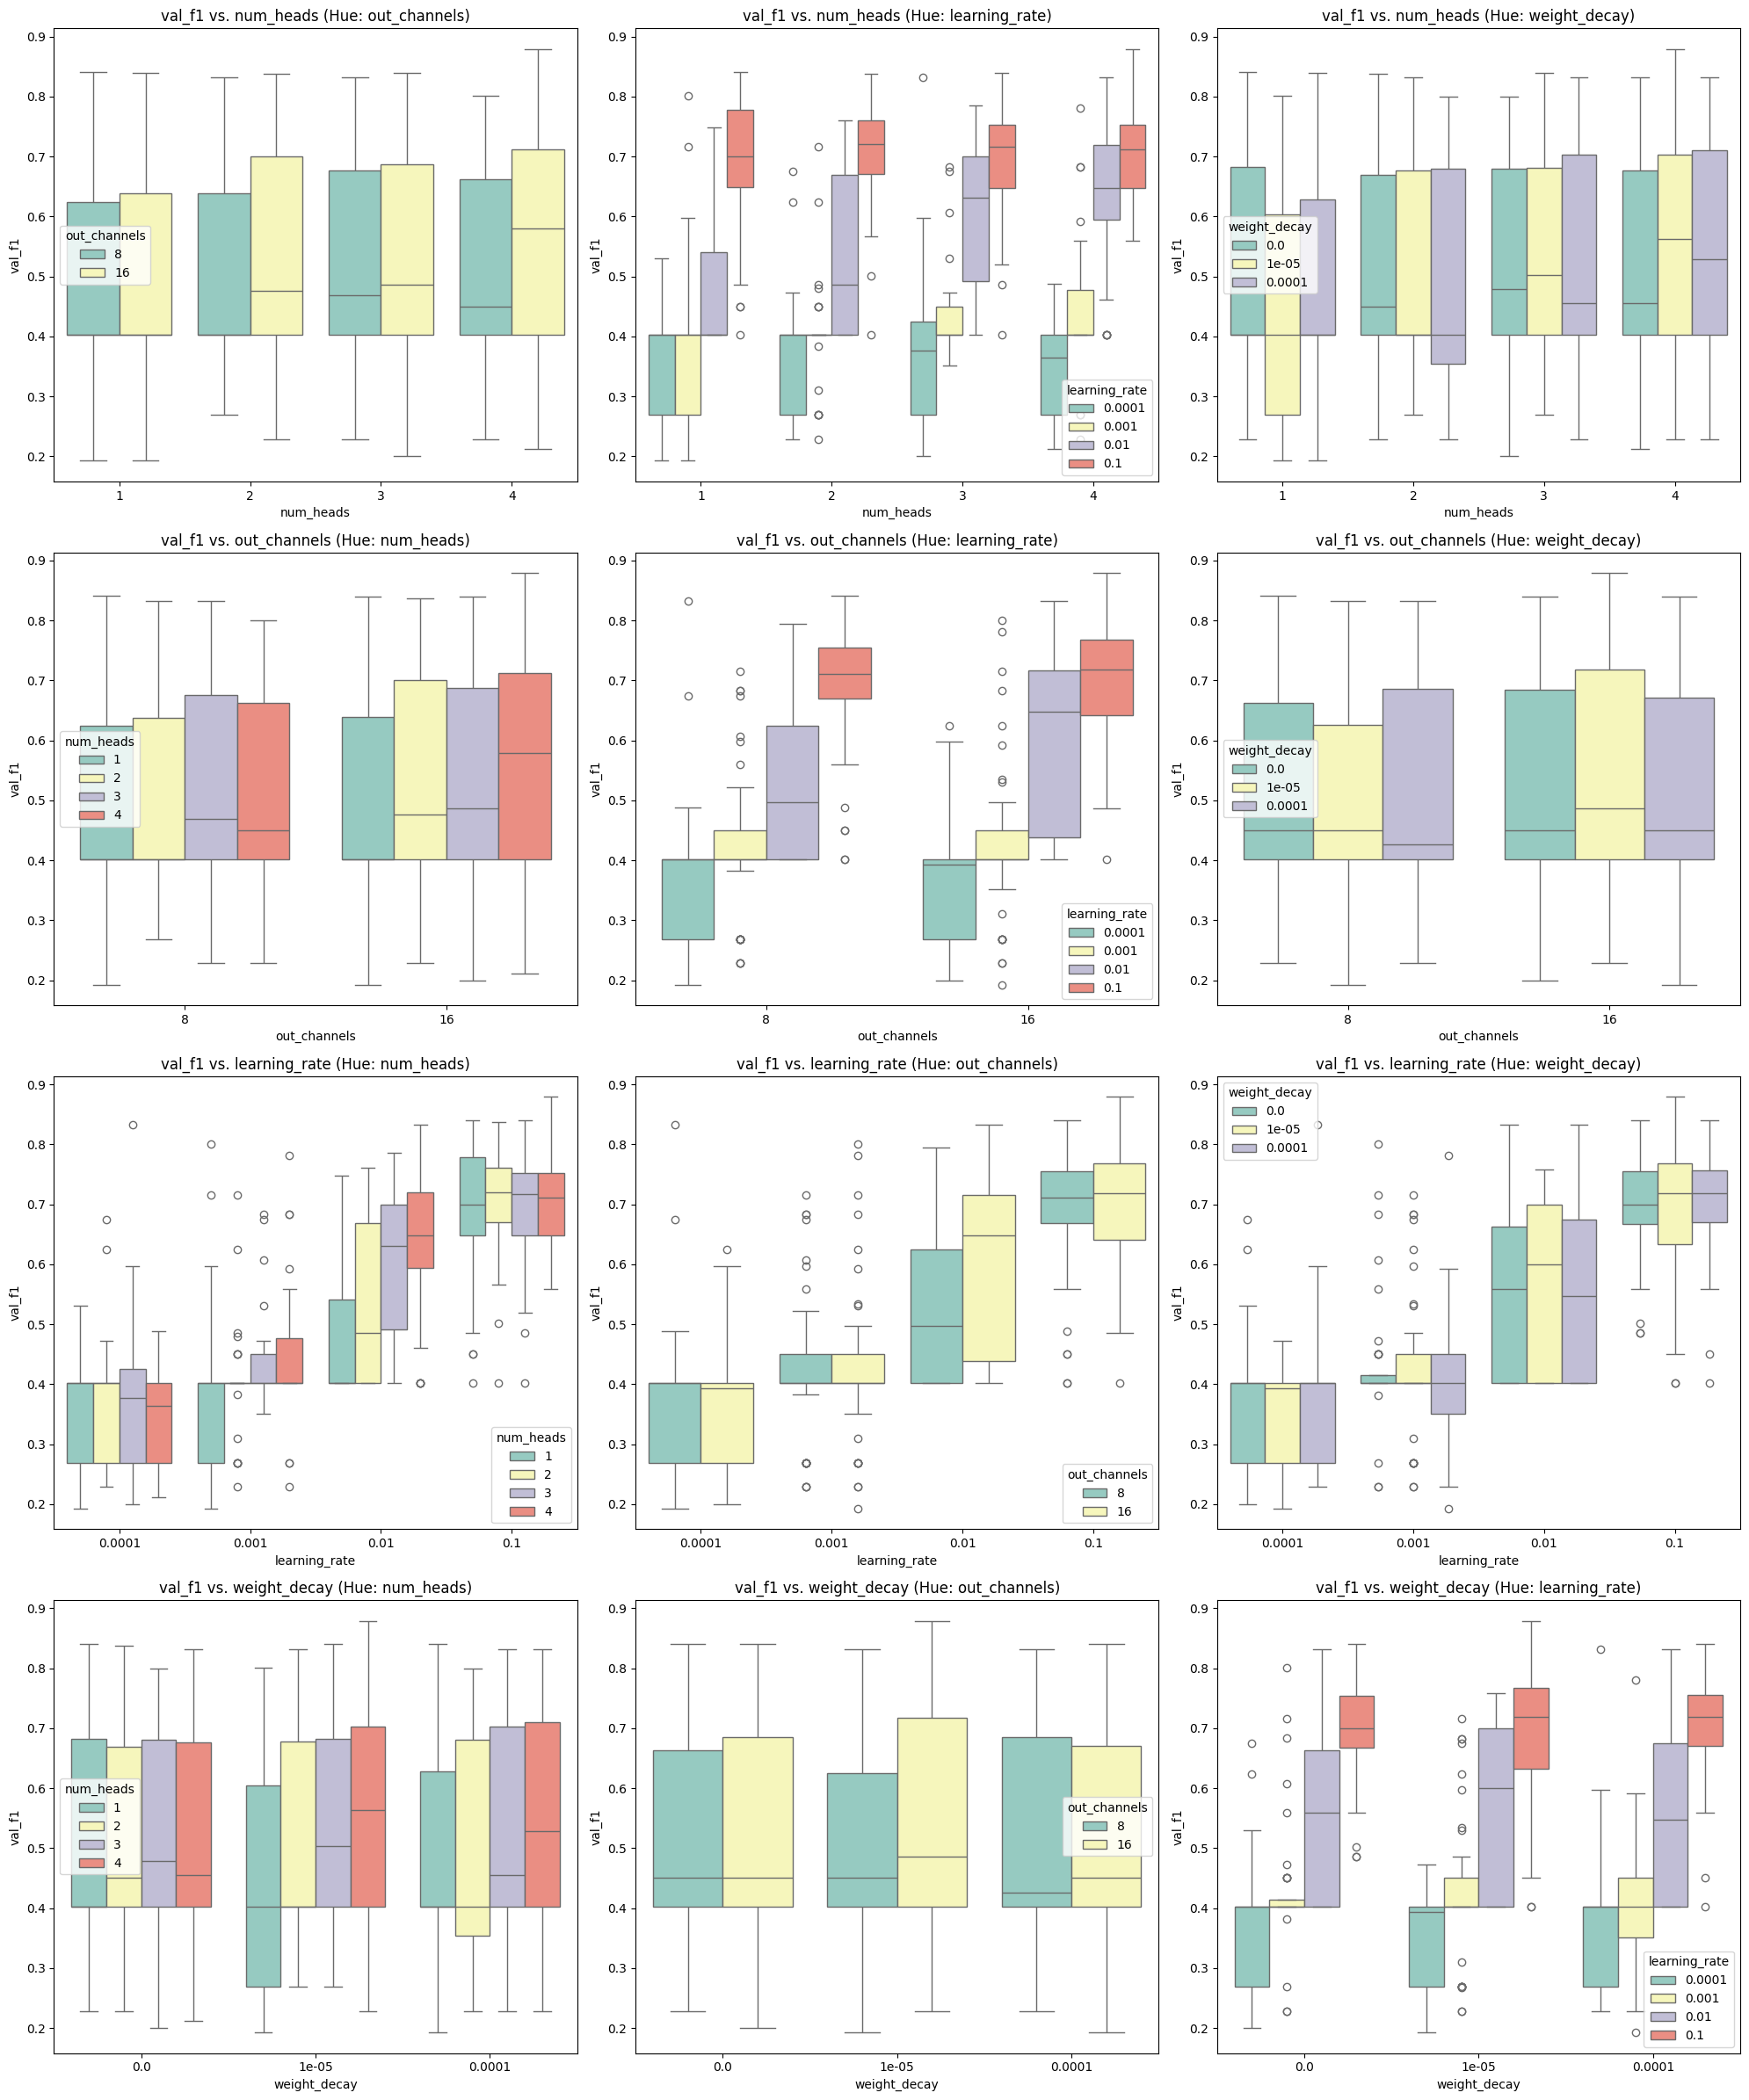

In [ ]:
from performance_visualizations import plot_hyperparameter_boxplots
plot_hyperparameter_boxplots(
    results_df=results_df_1,
    hyperparameters=['num_heads', 'out_channels', 'learning_rate', 'weight_decay'],
    metric='val_f1',
    use_hue=True
)

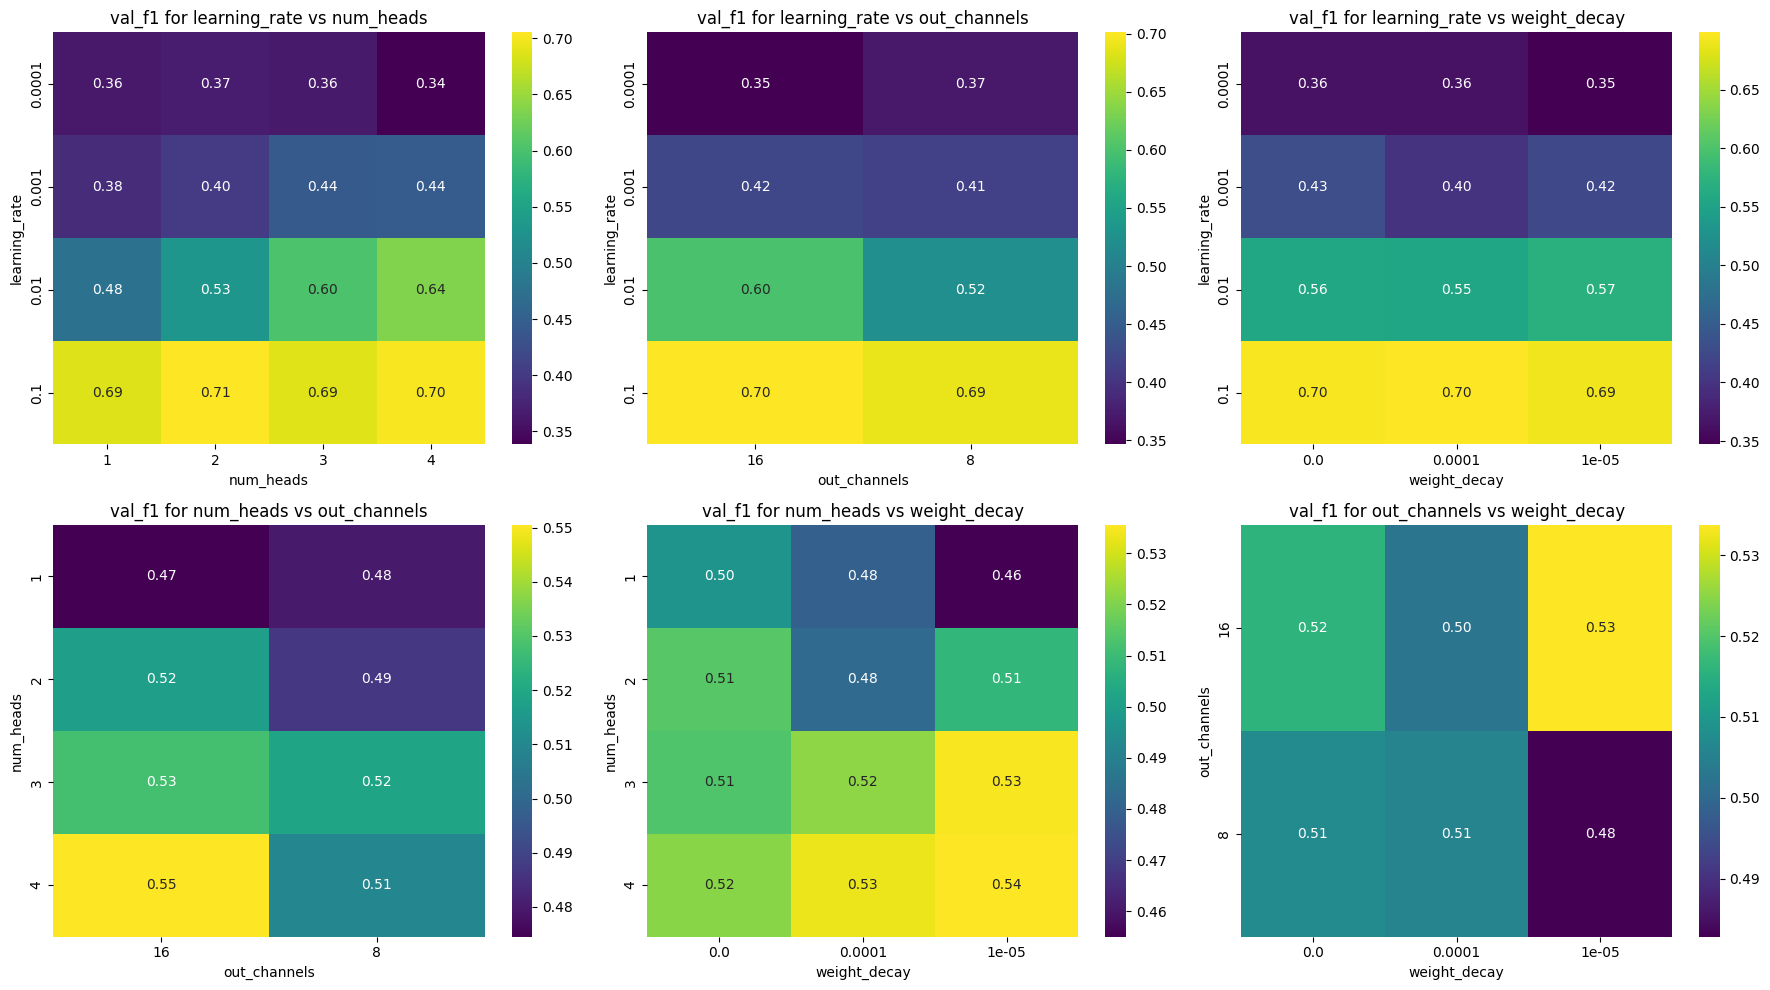

In [ ]:
from performance_visualizations import plot_hyperparameter_heatmaps
plot_hyperparameter_heatmaps(
    results_df=results_df_1,
    hyperparameters=['learning_rate', 'num_heads', 'out_channels', 'weight_decay'],
    metric='val_f1'
)

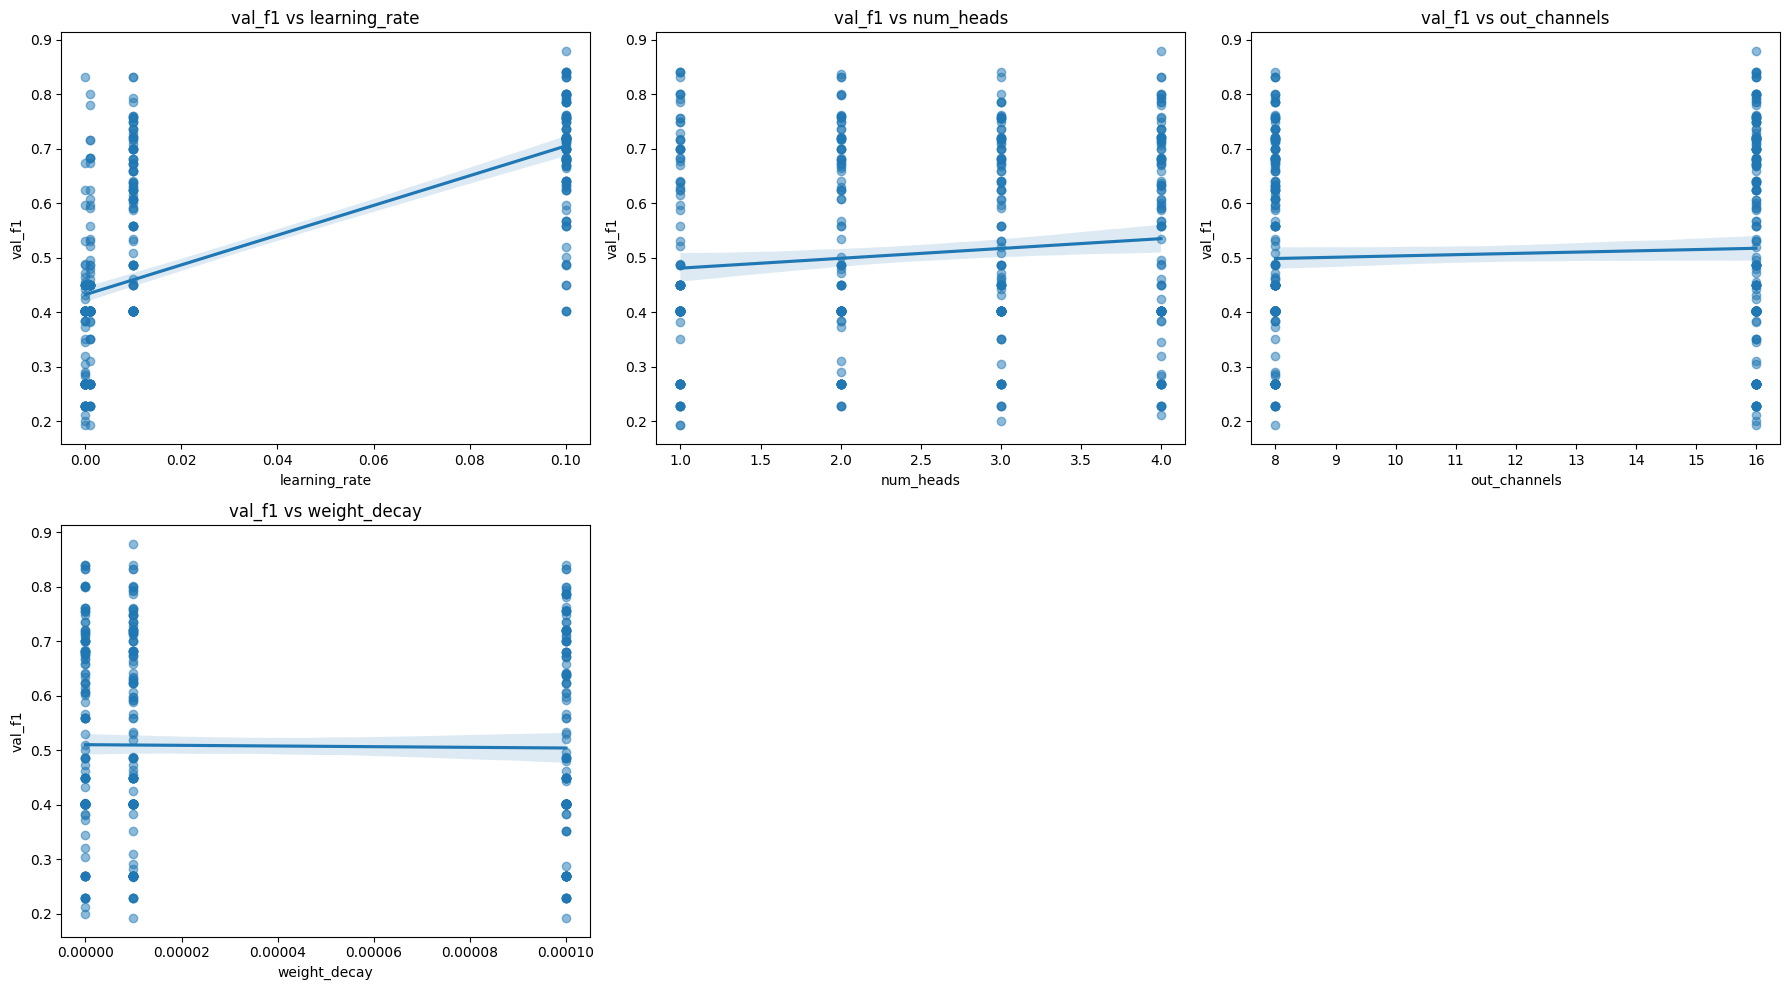

In [25]:
from performance_visualizations import plot_hyperparameter_scatterplots_with_regression
plot_hyperparameter_scatterplots_with_regression(
    results_df=results_df_1,
    hyperparameters=['learning_rate', 'num_heads', 'out_channels', 'weight_decay'],
    metric='val_f1'
)

In [3]:
"""
from performance_visualizations import plot_parallel_coordinates
plot_parallel_coordinates(
    results_df=results_df,
    hyperparameters=['learning_rate', 'num_heads', 'out_channels', 'weight_decay'],
    metric='val_f1',
    top_percentile=10
)
"""

"\nfrom performance_visualizations import plot_parallel_coordinates\nplot_parallel_coordinates(\n    results_df=results_df,\n    hyperparameters=['learning_rate', 'num_heads', 'out_channels', 'weight_decay'],\n    metric='val_f1',\n    top_percentile=10\n)\n"

In [10]:
# Second hyperparameter grid
param_grid = {
    'num_heads': [3, 4],
    'out_channels': [16],
    'num_epochs': [10],
    'learning_rate': [1e-1, 1e-2],
    'weight_decay': [0, 1e-5]
}

In [ ]:
# Perform second grid search with K-fold cross-validation on the training set
best_params_2, best_val_f1_2, best_val_accuracy_2, results_df_2 = perform_grid_search(
    train_graphs=train_graphs,
    train_labels=train_labels,
    num_splits=5,
    param_grid=param_grid,
    batch_size=32,
    model_class=GAT,
    device=device
)

In [53]:
print("Best Hyperparameters (based on average validation F1):")
print(best_params)
print(f"Best Average Validation F1 Score: {best_val_f1}")
print(f"Best Average Validation Accuracy: {best_val_accuracy}")

Best Hyperparameters (based on average validation F1):
{'num_heads': 4.0, 'out_channels': 16.0, 'learning_rate': 0.01, 'weight_decay': 0.0}
Best Average Validation F1 Score: 0.7742508162308672
Best Average Validation Accuracy: 0.7763440860215054


In [ ]:
# Save results_df to a CSV file for later analysis
results_df_2.to_csv('second_grid_search_sc_combined.csv', index=False)

In [13]:
import pandas as pd
results_df_2 = pd.read_csv('second_grid_search_sc_combined.csv')

In [15]:
from performance_visualizations import get_top_results
top_results_df_2 = get_top_results(
    results_df=results_df_2,
    hyperparameters=['learning_rate', 'num_heads', 'weight_decay', 'out_channels'],
    metric='val_f1',
    percentile=20,
    print_flag=True
)

c:\Users\barbo\brain classifier repo\brain_classifier\src1\performance_visualizations.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_results_df[hyperparameters] = top_results_df[hyperparameters].round(3)


,fold,val_f1,learning_rate,num_heads,weight_decay,out_channels
1,2,0.867006,0.10,3,0.0,16
26,2,0.835571,0.01,3,0.0,16
36,2,0.835571,0.01,4,0.0,16
11,2,0.806452,0.10,4,0.0,16
32,3,0.800893,0.01,4,0.0,16
6,2,0.800509,0.10,3,0.0,16
24,5,0.792344,0.01,3,0.0,16
29,5,0.792344,0.01,3,0.0,16
34,5,0.792344,0.01,4,0.0,16


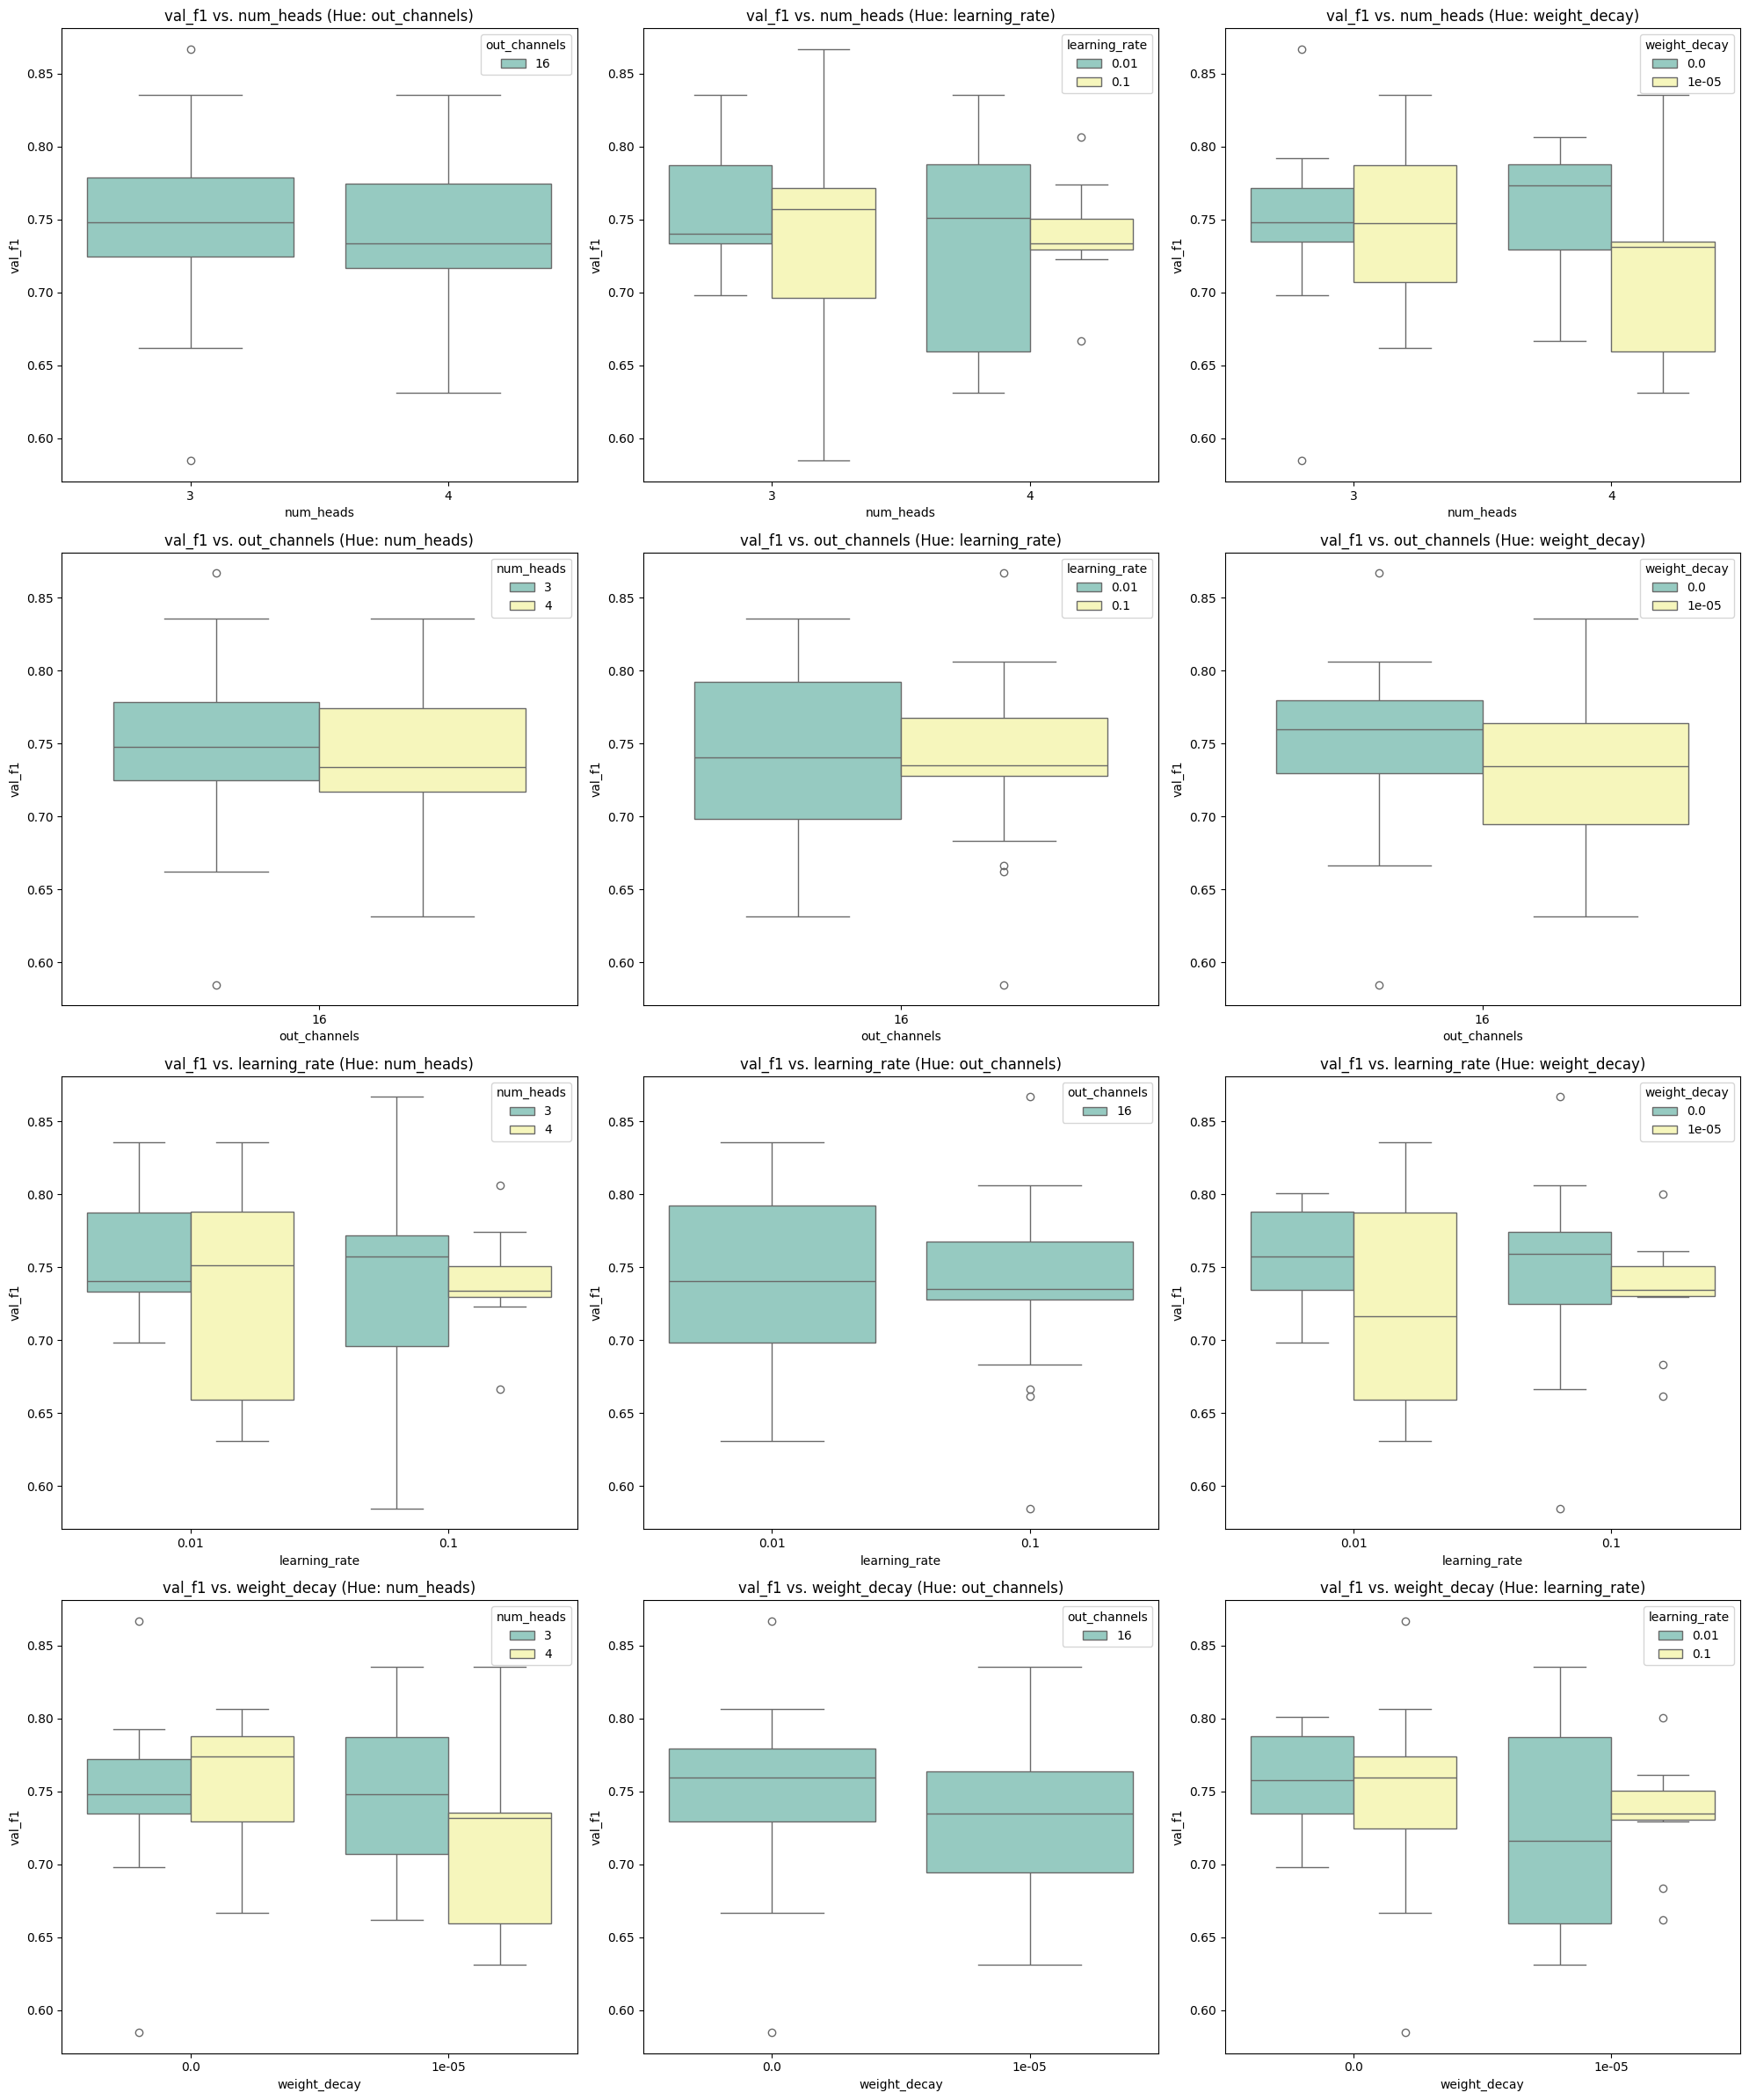

In [16]:
from performance_visualizations import plot_hyperparameter_boxplots
plot_hyperparameter_boxplots(
    results_df=results_df_2,
    hyperparameters=['num_heads', 'out_channels', 'learning_rate', 'weight_decay'],
    metric='val_f1',
    use_hue=True
)

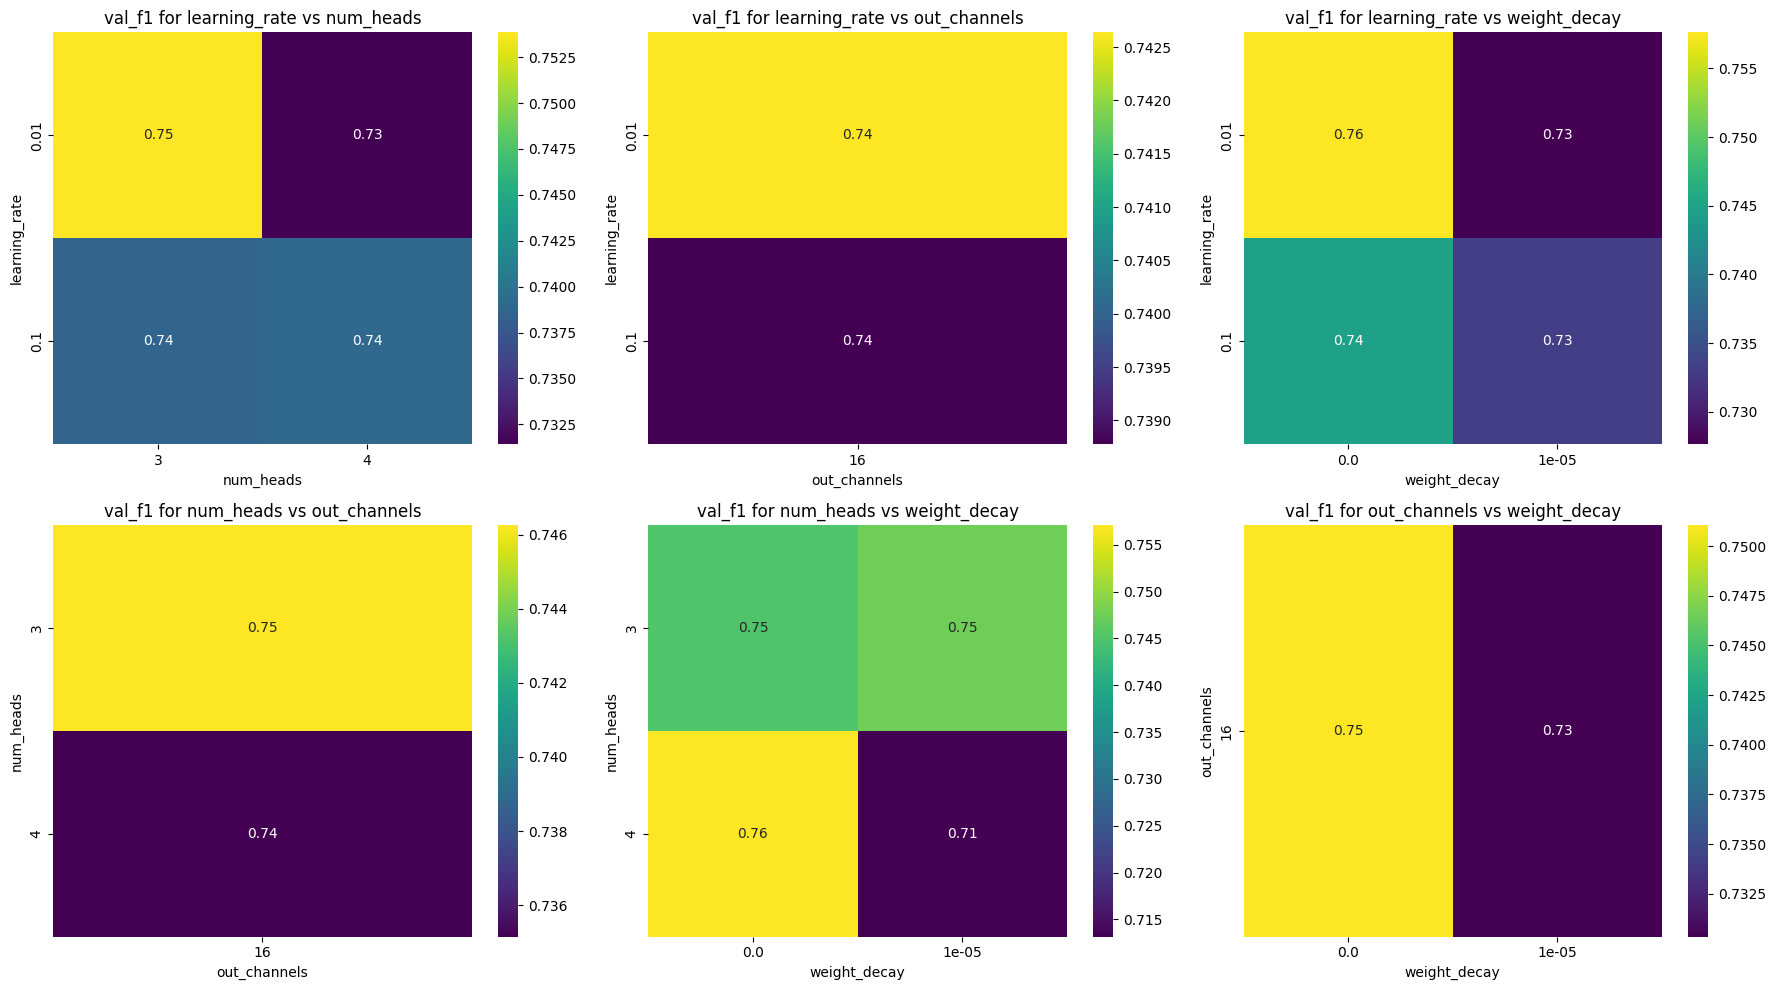

In [17]:
from performance_visualizations import plot_hyperparameter_heatmaps
plot_hyperparameter_heatmaps(
    results_df=results_df_2,
    hyperparameters=['learning_rate', 'num_heads', 'out_channels', 'weight_decay'],
    metric='val_f1'
)

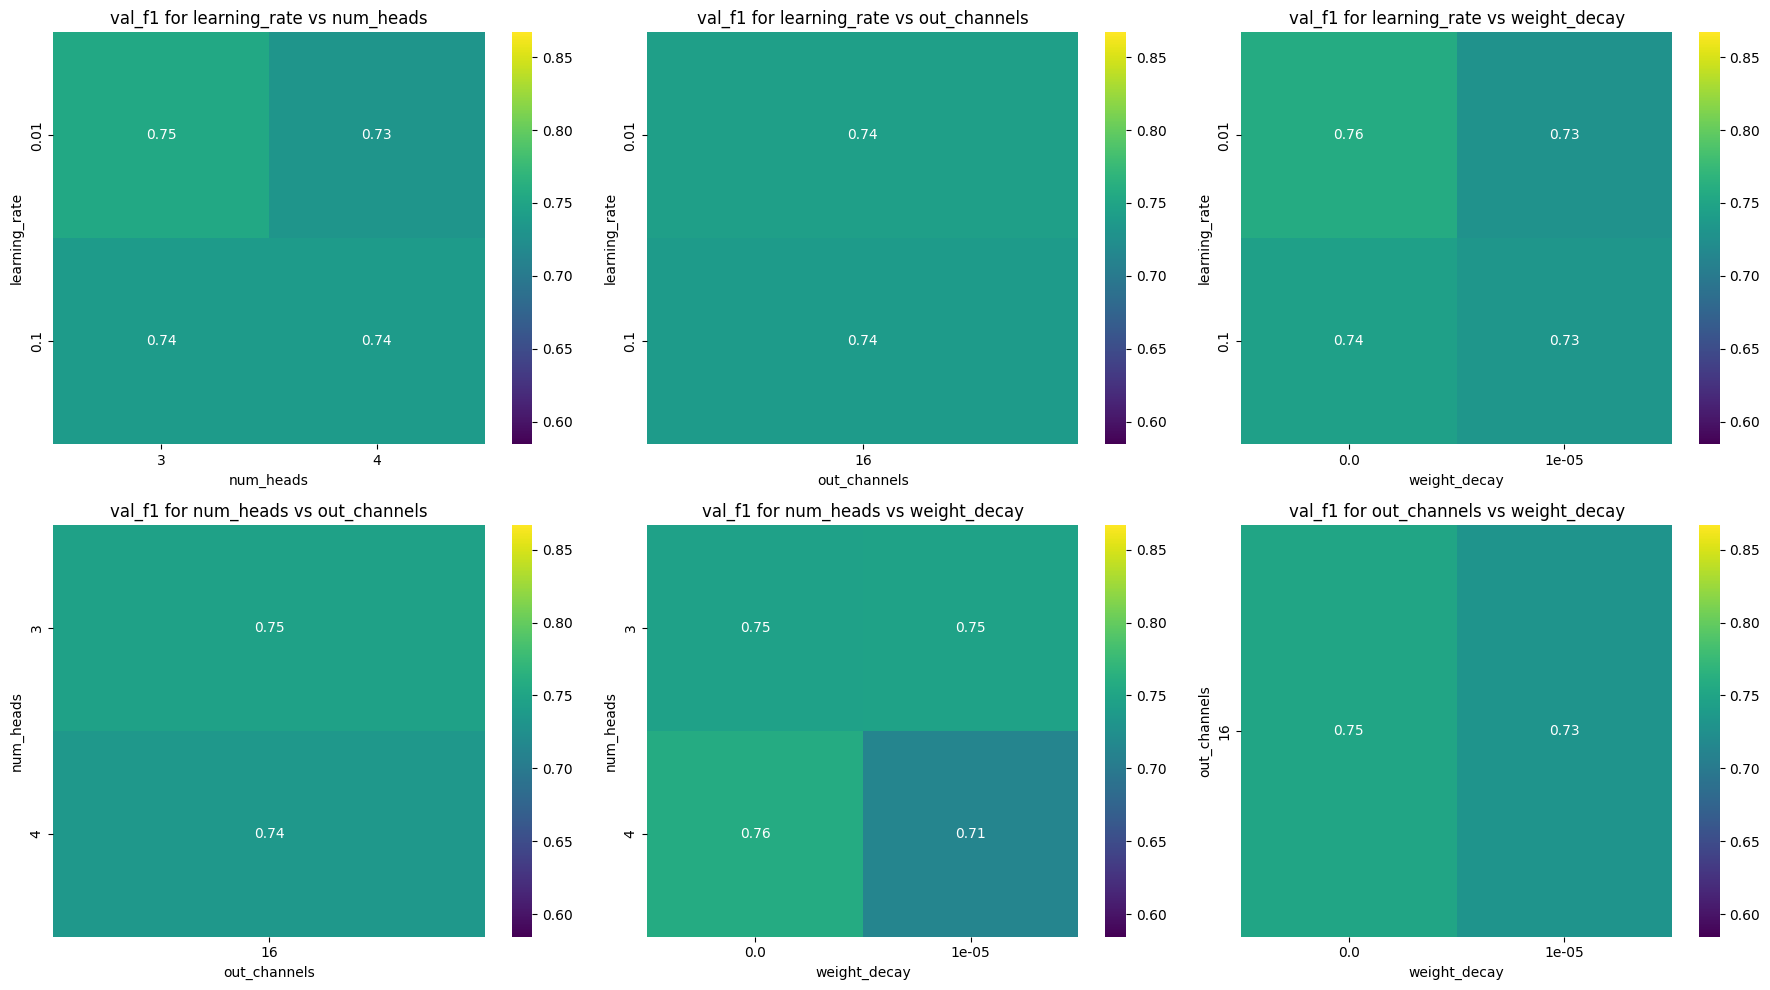

In [19]:
from performance_visualizations import plot_uniform_hyperparameter_heatmaps
plot_uniform_hyperparameter_heatmaps(
    results_df=results_df_2,
    hyperparameters=['learning_rate', 'num_heads', 'out_channels', 'weight_decay'],
    metric='val_f1'
)

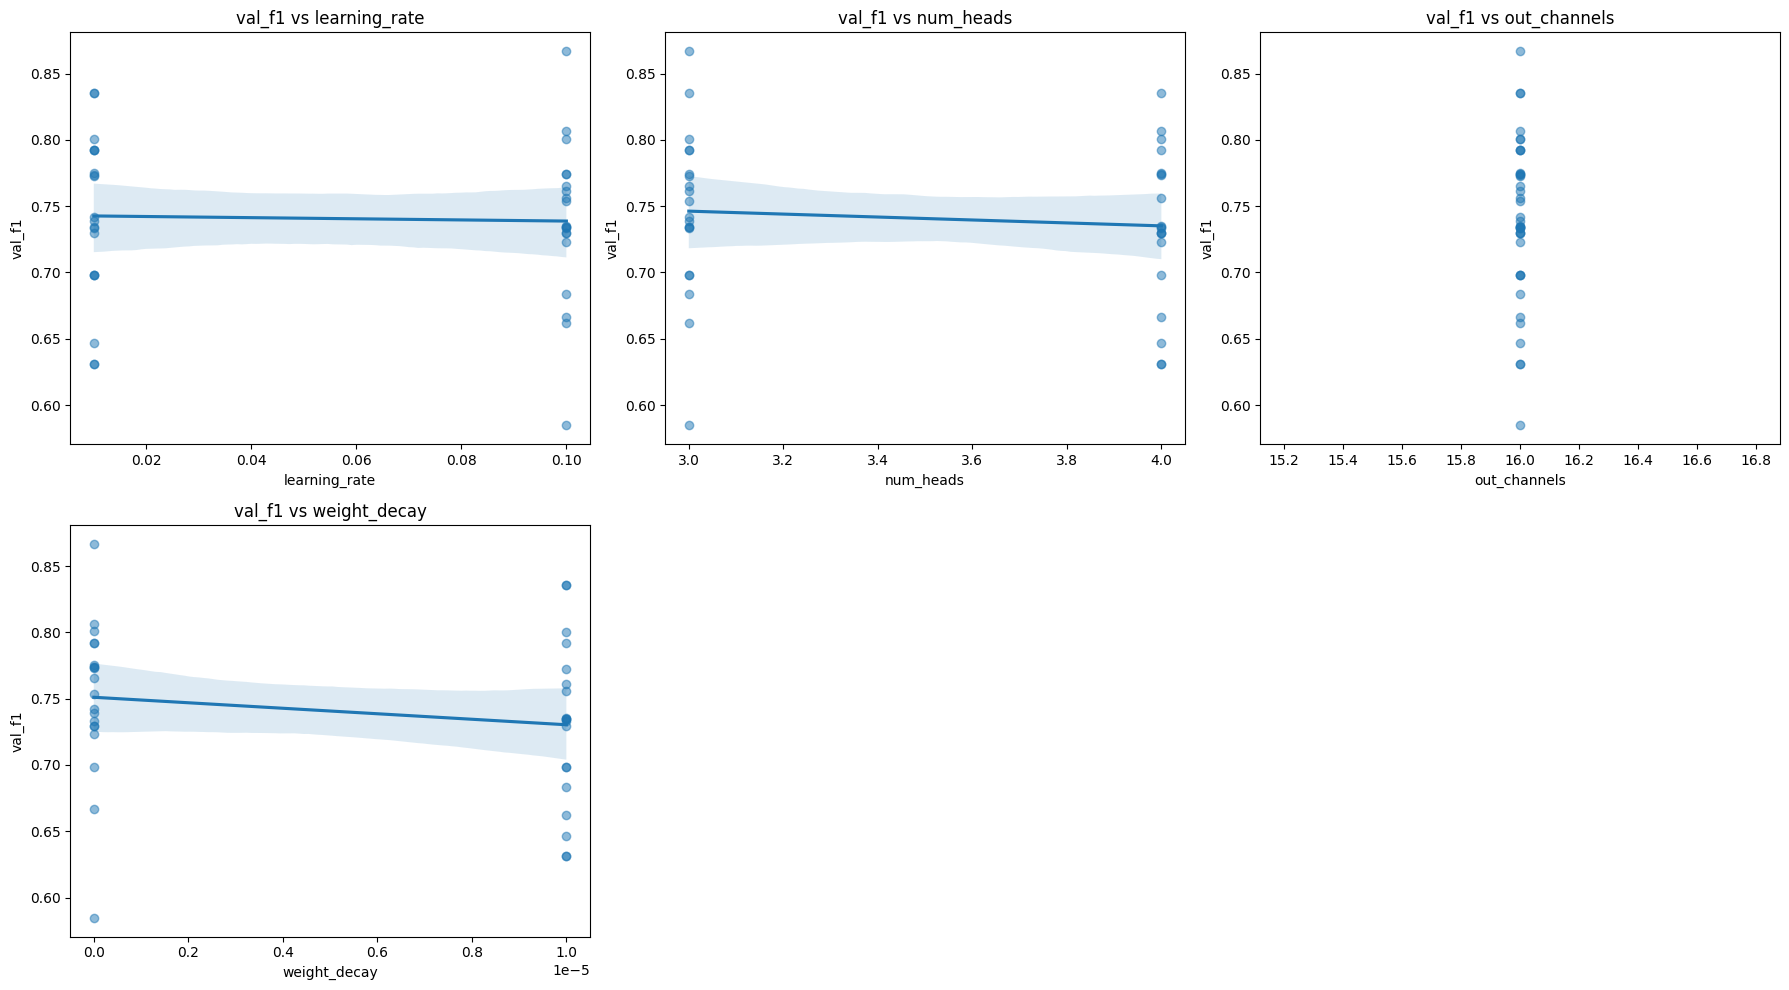

In [18]:
from performance_visualizations import plot_hyperparameter_scatterplots_with_regression
plot_hyperparameter_scatterplots_with_regression(
    results_df=results_df_2,
    hyperparameters=['learning_rate', 'num_heads', 'out_channels', 'weight_decay'],
    metric='val_f1'
)

In [ ]:
# Train the best model with early stopping

# Set the best hyperparameters
# These yelded best performance 
best_params = {
    'num_heads': 2,
    'out_channels': 8,
    'learning_rate': 0.001,
    'weight_decay': 0
}

train_model_with_early_stopping(
    train_graphs, 
    train_labels, 
    dataset_name='sc_fc',
    best_params = best_params, 
    patience=10, 
    max_epochs = 100, 
    batch_size=8, 
    device = device)

Epoch 1/100: Train Loss: 0.7004, Val Loss: 0.6970, Train F1: 0.2653, Val F1: 0.2516
Epoch 2/100: Train Loss: 0.6921, Val Loss: 0.6898, Train F1: 0.3959, Val F1: 0.5385
Epoch 3/100: Train Loss: 0.6870, Val Loss: 0.6831, Train F1: 0.5896, Val F1: 0.4221
Epoch 4/100: Train Loss: 0.6813, Val Loss: 0.6786, Train F1: 0.4895, Val F1: 0.4221
Epoch 5/100: Train Loss: 0.6765, Val Loss: 0.6739, Train F1: 0.4238, Val F1: 0.4221
Epoch 6/100: Train Loss: 0.6737, Val Loss: 0.6698, Train F1: 0.4062, Val F1: 0.4221
Epoch 7/100: Train Loss: 0.6707, Val Loss: 0.6664, Train F1: 0.4062, Val F1: 0.4221
Epoch 8/100: Train Loss: 0.6676, Val Loss: 0.6632, Train F1: 0.4062, Val F1: 0.4221
Epoch 9/100: Train Loss: 0.6640, Val Loss: 0.6601, Train F1: 0.4062, Val F1: 0.4221
Epoch 10/100: Train Loss: 0.6615, Val Loss: 0.6567, Train F1: 0.4062, Val F1: 0.4221
Epoch 11/100: Train Loss: 0.6586, Val Loss: 0.6533, Train F1: 0.4062, Val F1: 0.4221
Epoch 12/100: Train Loss: 0.6581, Val Loss: 0.6495, Train F1: 0.4238, Val F1: 0.4221
Epoch 13/100: Train Loss: 0.6498, Val Loss: 0.6459, Train F1: 0.4738, Val F1: 0.4221
Epoch 14/100: Train Loss: 0.6488, Val Loss: 0.6422, Train F1: 0.5342, Val F1: 0.4221
Epoch 15/100: Train Loss: 0.6449, Val Loss: 0.6383, Train F1: 0.5342, Val F1: 0.4221
Epoch 16/100: Train Loss: 0.6396, Val Loss: 0.6330, Train F1: 0.6267, Val F1: 0.6368
Epoch 17/100: Train Loss: 0.6329, Val Loss: 0.6279, Train F1: 0.6623, Val F1: 0.6368
Epoch 18/100: Train Loss: 0.6287, Val Loss: 0.6223, Train F1: 0.6556, Val F1: 0.6934
Epoch 19/100: Train Loss: 0.6218, Val Loss: 0.6163, Train F1: 0.6750, Val F1: 0.7931
Epoch 20/100: Train Loss: 0.6154, Val Loss: 0.6095, Train F1: 0.7290, Val F1: 0.7931
Epoch 21/100: Train Loss: 0.6094, Val Loss: 0.6026, Train F1: 0.7262, Val F1: 0.7931
Epoch 22/100: Train Loss: 0.6031, Val Loss: 0.5947, Train F1: 0.7355, Val F1: 0.7931
Epoch 23/100: Train Loss: 0.5951, Val Loss: 0.5890, Train F1: 0.7446, Val F1: 0.7931
Epoch 24/100: Train Loss: 0.5883, Val Loss: 0.5819, Train F1: 0.7446, Val F1: 0.7931
Epoch 25/100: Train Loss: 0.5804, Val Loss: 0.5765, Train F1: 0.7373, Val F1: 0.7931
Epoch 26/100: Train Loss: 0.5739, Val Loss: 0.5702, Train F1: 0.7373, Val F1: 0.7931
Epoch 27/100: Train Loss: 0.5678, Val Loss: 0.5641, Train F1: 0.7373, Val F1: 0.7931
Epoch 28/100: Train Loss: 0.5622, Val Loss: 0.5582, Train F1: 0.7373, Val F1: 0.8381
Epoch 29/100: Train Loss: 0.5597, Val Loss: 0.5538, Train F1: 0.7373, Val F1: 0.7931
Epoch 30/100: Train Loss: 0.5532, Val Loss: 0.5470, Train F1: 0.7373, Val F1: 0.8381
Epoch 31/100: Train Loss: 0.5462, Val Loss: 0.5427, Train F1: 0.7373, Val F1: 0.8381
Epoch 32/100: Train Loss: 0.5395, Val Loss: 0.5377, Train F1: 0.7226, Val F1: 0.8381
Epoch 33/100: Train Loss: 0.5365, Val Loss: 0.5338, Train F1: 0.7299, Val F1: 0.8381
Epoch 34/100: Train Loss: 0.5343, Val Loss: 0.5291, Train F1: 0.7226, Val F1: 0.8433
Epoch 35/100: Train Loss: 0.5278, Val Loss: 0.5256, Train F1: 0.7299, Val F1: 0.8381
Epoch 36/100: Train Loss: 0.5289, Val Loss: 0.5224, Train F1: 0.7299, Val F1: 0.8381
Epoch 37/100: Train Loss: 0.5236, Val Loss: 0.5177, Train F1: 0.7389, Val F1: 0.8433
Epoch 38/100: Train Loss: 0.5195, Val Loss: 0.5148, Train F1: 0.7389, Val F1: 0.8433
Epoch 39/100: Train Loss: 0.5161, Val Loss: 0.5128, Train F1: 0.7299, Val F1: 0.8381
Epoch 40/100: Train Loss: 0.5113, Val Loss: 0.5105, Train F1: 0.7299, Val F1: 0.8808
Epoch 41/100: Train Loss: 0.5105, Val Loss: 0.5066, Train F1: 0.7299, Val F1: 0.8808
Epoch 42/100: Train Loss: 0.5120, Val Loss: 0.5028, Train F1: 0.7478, Val F1: 0.8433
Epoch 43/100: Train Loss: 0.5027, Val Loss: 0.5016, Train F1: 0.7491, Val F1: 0.8433
Epoch 44/100: Train Loss: 0.5066, Val Loss: 0.4986, Train F1: 0.7478, Val F1: 0.8433
Epoch 45/100: Train Loss: 0.5044, Val Loss: 0.4982, Train F1: 0.7299, Val F1: 0.8808
Epoch 46/100: Train Loss: 0.5001, Val Loss: 0.4956, Train F1: 0.7463, Val F1: 0.8433
Epoch 47/100: Train Loss: 0.4970, Val Loss: 0.4936, Train F1: 0.7389, Val F1: 0.8808
Epoch 48/100: Train Loss: 0.4943, Val Loss: 0.4917, Train F1: 0.7478, Val F1: 0.8808
Epoch 49/100: Train Loss: 0.4944, Val Loss: 0.4898, Train F1: 0.7478, Val F1: 0.8808
Epoch 50/100: Train Loss: 0.4913, Val Loss: 0.4876, Train F1: 0.7478, Val F1: 0.8808
Epoch 51/100: Train Loss: 0.4919, Val Loss: 0.4865, Train F1: 0.7566, Val F1: 0.8808
Epoch 52/100: Train Loss: 0.4863, Val Loss: 0.4845, Train F1: 0.7566, Val F1: 0.8808
Epoch 53/100: Train Loss: 0.4913, Val Loss: 0.4817, Train F1: 0.7653, Val F1: 0.8433
Epoch 54/100: Train Loss: 0.4866, Val Loss: 0.4805, Train F1: 0.7664, Val F1: 0.8433
Epoch 55/100: Train Loss: 0.4877, Val Loss: 0.4799, Train F1: 0.7653, Val F1: 0.8808
Epoch 56/100: Train Loss: 0.4830, Val Loss: 0.4783, Train F1: 0.7653, Val F1: 0.8808
Epoch 57/100: Train Loss: 0.4822, Val Loss: 0.4770, Train F1: 0.7728, Val F1: 0.8808
Epoch 58/100: Train Loss: 0.4798, Val Loss: 0.4750, Train F1: 0.7728, Val F1: 0.8808
Epoch 59/100: Train Loss: 0.4797, Val Loss: 0.4735, Train F1: 0.7740, Val F1: 0.8433
Epoch 60/100: Train Loss: 0.4774, Val Loss: 0.4755, Train F1: 0.7641, Val F1: 0.8808
Epoch 61/100: Train Loss: 0.4777, Val Loss: 0.4746, Train F1: 0.7803, Val F1: 0.8808
Epoch 62/100: Train Loss: 0.4764, Val Loss: 0.4707, Train F1: 0.7728, Val F1: 0.8808
Epoch 63/100: Train Loss: 0.4781, Val Loss: 0.4674, Train F1: 0.7740, Val F1: 0.8062
Epoch 64/100: Train Loss: 0.4802, Val Loss: 0.4672, Train F1: 0.7664, Val F1: 0.8808
Epoch 65/100: Train Loss: 0.4718, Val Loss: 0.4662, Train F1: 0.7740, Val F1: 0.8808
Epoch 66/100: Train Loss: 0.4748, Val Loss: 0.4676, Train F1: 0.7728, Val F1: 0.8808
Epoch 67/100: Train Loss: 0.4682, Val Loss: 0.4636, Train F1: 0.7740, Val F1: 0.8808
Epoch 68/100: Train Loss: 0.4687, Val Loss: 0.4620, Train F1: 0.7815, Val F1: 0.8433
Epoch 69/100: Train Loss: 0.4736, Val Loss: 0.4629, Train F1: 0.7728, Val F1: 0.8808
Epoch 70/100: Train Loss: 0.4648, Val Loss: 0.4613, Train F1: 0.7815, Val F1: 0.8808
Epoch 71/100: Train Loss: 0.4656, Val Loss: 0.4591, Train F1: 0.7815, Val F1: 0.8433
Epoch 72/100: Train Loss: 0.4722, Val Loss: 0.4588, Train F1: 0.7815, Val F1: 0.8808
Epoch 73/100: Train Loss: 0.4677, Val Loss: 0.4564, Train F1: 0.7815, Val F1: 0.8433
Epoch 74/100: Train Loss: 0.4614, Val Loss: 0.4564, Train F1: 0.7815, Val F1: 0.8808
Epoch 75/100: Train Loss: 0.4621, Val Loss: 0.4569, Train F1: 0.7815, Val F1: 0.8808
Epoch 76/100: Train Loss: 0.4663, Val Loss: 0.4557, Train F1: 0.7815, Val F1: 0.8808
Epoch 77/100: Train Loss: 0.4638, Val Loss: 0.4530, Train F1: 0.7815, Val F1: 0.8433
Epoch 78/100: Train Loss: 0.4638, Val Loss: 0.4501, Train F1: 0.7826, Val F1: 0.8062
Epoch 79/100: Train Loss: 0.4613, Val Loss: 0.4514, Train F1: 0.7826, Val F1: 0.8808
Epoch 80/100: Train Loss: 0.4602, Val Loss: 0.4530, Train F1: 0.7815, Val F1: 0.8808
Epoch 81/100: Train Loss: 0.4586, Val Loss: 0.4484, Train F1: 0.7815, Val F1: 0.8062
Epoch 82/100: Train Loss: 0.4560, Val Loss: 0.4499, Train F1: 0.7901, Val F1: 0.8808
Epoch 83/100: Train Loss: 0.4563, Val Loss: 0.4461, Train F1: 0.7815, Val F1: 0.8062
Epoch 84/100: Train Loss: 0.4567, Val Loss: 0.4469, Train F1: 0.7891, Val F1: 0.8808
Epoch 85/100: Train Loss: 0.4625, Val Loss: 0.4439, Train F1: 0.7901, Val F1: 0.8062
Epoch 86/100: Train Loss: 0.4593, Val Loss: 0.4419, Train F1: 0.7926, Val F1: 0.8062
Epoch 87/100: Train Loss: 0.4594, Val Loss: 0.4446, Train F1: 0.7901, Val F1: 0.8808
Epoch 88/100: Train Loss: 0.4508, Val Loss: 0.4420, Train F1: 0.7901, Val F1: 0.8062
Epoch 89/100: Train Loss: 0.4545, Val Loss: 0.4438, Train F1: 0.7977, Val F1: 0.8808
Epoch 90/100: Train Loss: 0.4492, Val Loss: 0.4405, Train F1: 0.7901, Val F1: 0.8062
Epoch 91/100: Train Loss: 0.4546, Val Loss: 0.4392, Train F1: 0.7901, Val F1: 0.8062
Epoch 92/100: Train Loss: 0.4485, Val Loss: 0.4394, Train F1: 0.7901, Val F1: 0.8062
Epoch 93/100: Train Loss: 0.4470, Val Loss: 0.4375, Train F1: 0.7987, Val F1: 0.8062
Epoch 94/100: Train Loss: 0.4454, Val Loss: 0.4365, Train F1: 0.7901, Val F1: 0.8062
Epoch 95/100: Train Loss: 0.4454, Val Loss: 0.4367, Train F1: 0.7891, Val F1: 0.8062
Epoch 96/100: Train Loss: 0.4564, Val Loss: 0.4392, Train F1: 0.7966, Val F1: 0.8381
Epoch 97/100: Train Loss: 0.4473, Val Loss: 0.4311, Train F1: 0.7911, Val F1: 0.8062
Epoch 98/100: Train Loss: 0.4447, Val Loss: 0.4329, Train F1: 0.7919, Val F1: 0.8062
Epoch 99/100: Train Loss: 0.4412, Val Loss: 0.4315, Train F1: 0.7987, Val F1: 0.8062
Epoch 100/100: Train Loss: 0.4430, Val Loss: 0.4292, Train F1: 0.7995, Val F1: 0.8062


In [7]:
param_grid_1 = { 
    'num_heads': [1,2,3],
    'out_channels': [8],
    'learning_rate': [0.01, 0.001],
    'weight_decay': [0]
}

In [9]:
param_grid_1 = { 
    'num_heads': [2],
    'out_channels': [8],
    'learning_rate': [ 0.001],
    'weight_decay': [0]
}

In [11]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Perform grid search with K-fold cross-validation on the training set
best_params_1, best_val_f1_1, best_val_accuracy_1, best_epochs_trained_1, results_df_1 = perform_cv_early_stopping(
    train_graphs=train_graphs,
    train_labels=train_labels,
    num_splits=2,
    param_grid=param_grid_1,
    batch_size=8,
    device=device,
    patience = 2,
    max_epochs = 2
)



In [21]:
print("Best Hyperparameters (based on average validation F1):")
print(best_params1)
print(f"Best Average Validation F1 Score: {best_val_f1_1}")
print(f"Best Average Validation Accuracy: {best_val_accuracy_1}")

Best Hyperparameters (based on average validation F1):
{'num_heads': 1.0, 'out_channels': 8.0, 'learning_rate': 0.01, 'weight_decay': 0.0}
Best Average Validation F1 Score: 0.7914830377367619
Best Average Validation Accuracy: 0.7950537634408603


In [ ]:
# Save results_df to a CSV file for later analysis
#results_df.to_csv('first_grid_search_sc_combined.csv', index=False)

import pandas as pd
results_df = pd.read_csv('grid_search_sc_combined.csv')

from performance_visualizations import get_top_results

top_results_df_1 = get_top_results(
    results_df=results_df_1,
    hyperparameters=['learning_rate', 'num_heads', 'weight_decay', 'out_channels'],
    metric='val_f1',
    percentile=2,
    print_flag=True
)

In [12]:
# Train the best model with early stopping

# Set the best hyperparameters
best_params = {
    'num_heads': 2,
    'out_channels': 8,
    'learning_rate': 0.001,
    'weight_decay': 0
}


Fold 1/5
Epoch 1/100: Train Loss: 0.7061, Val Loss: 0.6951, Train F1: 0.2668, Val F1: 0.2478
Epoch 2/100: Train Loss: 0.6952, Val Loss: 0.6888, Train F1: 0.4218, Val F1: 0.7217
Epoch 3/100: Train Loss: 0.6848, Val Loss: 0.6837, Train F1: 0.5243, Val F1: 0.4266
Epoch 4/100: Train Loss: 0.6770, Val Loss: 0.6791, Train F1: 0.4578, Val F1: 0.4266
Epoch 5/100: Train Loss: 0.6762, Val Loss: 0.6746, Train F1: 0.4044, Val F1: 0.4266
Epoch 6/100: Train Loss: 0.6816, Val Loss: 0.6720, Train F1: 0.4044, Val F1: 0.4266
Epoch 7/100: Train Loss: 0.6791, Val Loss: 0.6700, Train F1: 0.4044, Val F1: 0.4266
Epoch 8/100: Train Loss: 0.6656, Val Loss: 0.6683, Train F1: 0.4044, Val F1: 0.4266
Epoch 9/100: Train Loss: 0.6702, Val Loss: 0.6657, Train F1: 0.4044, Val F1: 0.4266
Epoch 10/100: Train Loss: 0.6726, Val Loss: 0.6634, Train F1: 0.4044, Val F1: 0.4266
Epoch 11/100: Train Loss: 0.6563, Val Loss: 0.6613, Train F1: 0.4228, Val F1: 0.4266
Epoch 12/100: Train Loss: 0.6551, Val Loss: 0.6586, Train F1: 0.4

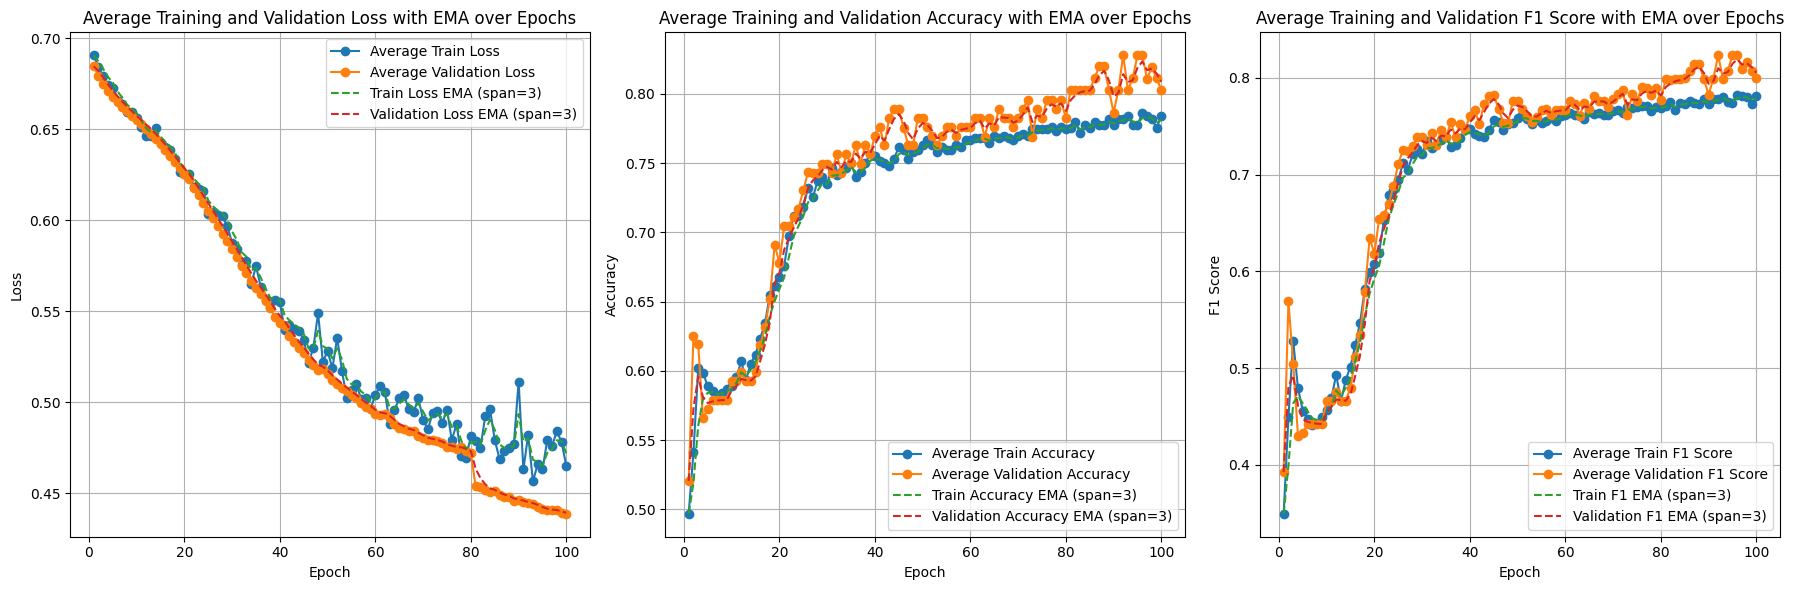

In [13]:
import torch
from train_cv_early_stopping import train_model_with_early_stopping_cv
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_model_with_early_stopping_cv(
    train_graphs, 
    train_labels, 
    dataset_name = 'sc_fc', 
    best_params=best_params, 
    patience = 10, 
    max_epochs=100, 
    batch_size = 8, 
    device = device, 
    num_splits = 5, 
    model_save_path = "model_1_sc_fc.pth")

Epoch 1/100: Train Loss: 0.7327, Val Loss: 0.7278, Train F1: 0.2653, Val F1: 0.2516
Epoch 2/100: Train Loss: 0.7228, Val Loss: 0.7192, Train F1: 0.2653, Val F1: 0.2516
Epoch 3/100: Train Loss: 0.7160, Val Loss: 0.7119, Train F1: 0.2653, Val F1: 0.2516
Epoch 4/100: Train Loss: 0.7091, Val Loss: 0.7071, Train F1: 0.2653, Val F1: 0.2516
Epoch 5/100: Train Loss: 0.7051, Val Loss: 0.7027, Train F1: 0.2653, Val F1: 0.2516
Epoch 6/100: Train Loss: 0.7006, Val Loss: 0.6987, Train F1: 0.3205, Val F1: 0.3548
Epoch 7/100: Train Loss: 0.6970, Val Loss: 0.6959, Train F1: 0.4098, Val F1: 0.4647
Epoch 8/100: Train Loss: 0.6937, Val Loss: 0.6939, Train F1: 0.5068, Val F1: 0.4962
Epoch 9/100: Train Loss: 0.6913, Val Loss: 0.6921, Train F1: 0.5320, Val F1: 0.4793
Epoch 10/100: Train Loss: 0.6896, Val Loss: 0.6899, Train F1: 0.4844, Val F1: 0.4038
Epoch 11/100: Train Loss: 0.6871, Val Loss: 0.6886, Train F1: 0.4531, Val F1: 0.4038
Epoch 12/100: Train Loss: 0.6864, Val Loss: 0.6867, Train F1: 0.4576, Val 

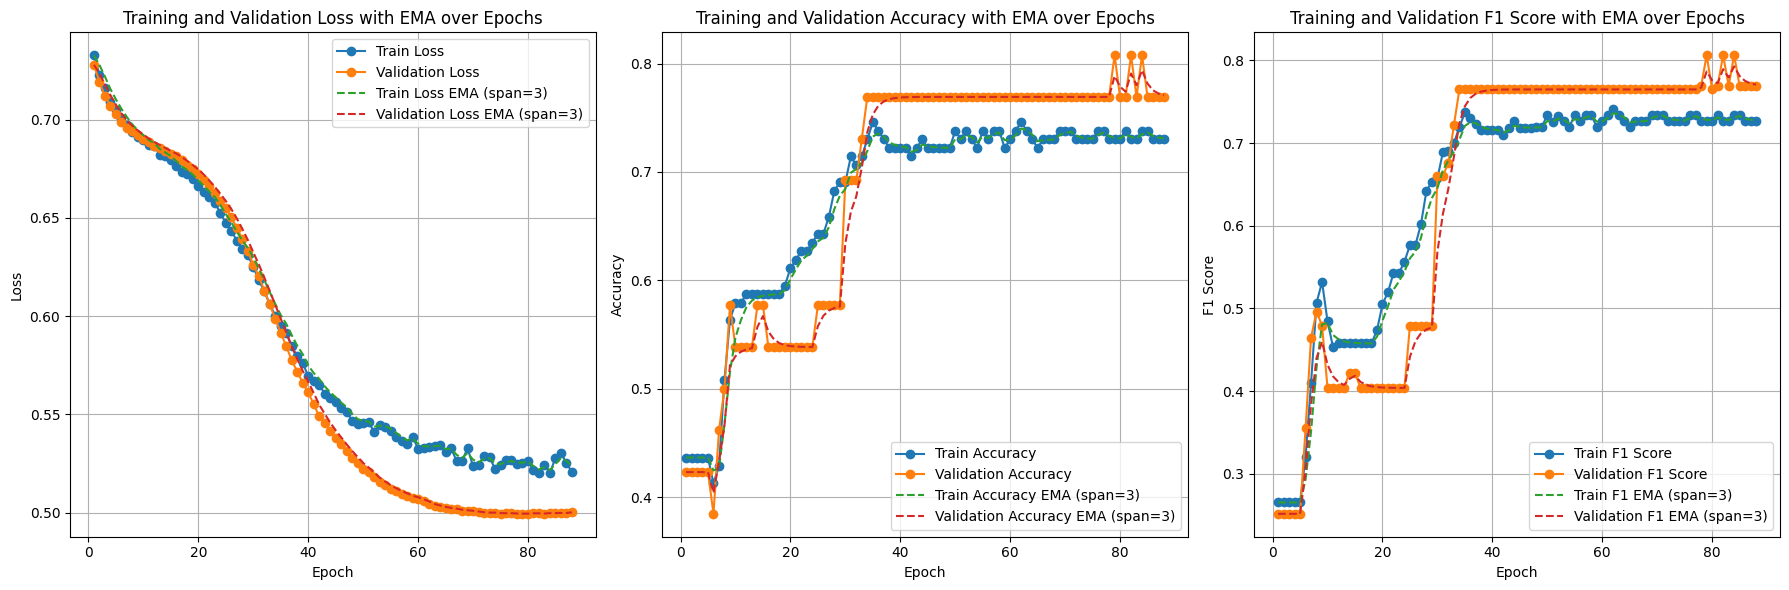

In [16]:
from train_best_model import train_model_with_early_stopping
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_model_with_early_stopping(
    train_graphs, 
    train_labels, 
    dataset_name='sc_fc',
    best_params = best_params, 
    patience=10, 
    max_epochs = 100, 
    batch_size=8, 
    device = device)

In [71]:
best_model_path = os.path.join(base_dir, 'src1', 'best_model_sc_fc.pth')

In [72]:
from test_best_model import test_model
test_model(
    model_path=best_model_path,
    graphs=test_graphs,
    labels=test_labels
)

Test Loss: 0.3338, Test Accuracy: 0.9259, Test F1: 0.9259
